In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from datetime import datetime
from heapq import heappush,heappop
from collections import Counter,defaultdict
import multiprocessing as mp
import tensorflow as tf
from sklearn.utils import shuffle
import time

PATH="/home/yui/Documents/data/recommender/movieLens20M/rating.csv"
df = pd.read_csv(PATH)

def findNMatches(df,targetUser,leastCommon=25,minMoviesWatched=50,noRef=25):
    tardf = df[df["userId"]==targetUser]
    u2m = defaultdict(dict)
    valCountsUserId = df["userId"].value_counts()

    for j in range(tardf.shape[0]):
        movieId = tardf.iloc[j]["movieId"]
        u2m[targetUser][movieId] = tardf.iloc[j]["rating"]
    avg = np.array(list(u2m[targetUser].values())).mean()
    u2m[targetUser] = (u2m[targetUser],avg)
    tarSet = set(u2m[targetUser][0])
    # print(tarSet)
    prevId,storeSet,storeDict = 0,set(),dict()
    for i in tqdm(range(df.shape[0])):
        row = df.iloc[i]
        userId = row["userId"]
        if valCountsUserId[userId]<minMoviesWatched:
            continue
        if userId==targetUser:
            continue
        if userId!=prevId:
            if len(tarSet&storeSet)>=leastCommon:
                avg = np.array(list(storeDict.values())).mean()
                u2m[prevId]=(storeDict,avg)
            storeSet,storeDict=set(),dict()
        prevId = userId
        storeSet.add(row["movieId"])
        storeDict[row["movieId"]]=row["rating"]
        if len(u2m)>noRef:
            break
    return u2m

class MF:
    def __init__(self,u2m,K=100,penalty=0.1):
        self.u2m = u2m
        self.penalty = penalty
        self.K = K
        self.allmovies = dict()
        self.mean,i=0,0
        for candidate in u2m:
            for movie in u2m[candidate][0]:
                t,c = self.allmovies.get(movie,(0,0))
                c+=1
                t+=u2m[candidate][0][movie]
                self.allmovies[movie]=(t,c)
                i+=1
                self.mean+=u2m[candidate][0][movie]
        self.mean/=i
        for movie in self.allmovies:
            t,c = self.allmovies[movie]
            self.allmovies[movie] = (t/c,c)
        self.m2id = {key:i for i,key in enumerate(self.allmovies)}
        self.id2m = {i:key for i,key in enumerate(self.allmovies)}
        self.u2id = {key:i for i,key in enumerate(u2m)}
        self.id2u = {i:key for i,key in enumerate(u2m)}
        self.N = len(u2m)
        self.M = len(self.allmovies)

In [2]:
class dnnMF:
    def __init__(self,df,targetUser,K=100,
                 split=0.85,batch_size=16,hidden=128):
        self.u2m = findNMatches(df,targetUser)
        self.mf = MF(self.u2m,K=K)
        tdf = df[df["userId"].isin(list(self.u2m.keys()))]
        self.tdf = shuffle(tdf)
        self.split = split
        self.batch_size = batch_size
        self.hidden = hidden
        self.prepareData()
        self.getModel()
    def getX1X2Y(self,dataset):
        w = [self.mf.u2id[i] for i in list(dataset['userId'])]
        XW = np.array(w).reshape(-1,1,1)
        u = [self.mf.m2id[i] for i in list(dataset['movieId'])]
        XU = np.array(u).reshape(-1,1,1)
        Y = np.array(dataset['rating'])-self.mf.mean
        return XW,XU,Y
    def prepareData(self):
        trainSet = self.tdf.iloc[:int(self.split*self.tdf.shape[0])]
        testSet = self.tdf.iloc[int(self.split*self.tdf.shape[0]):]
        trainXW,trainXU,trainY = self.getX1X2Y(trainSet)
        testXW,testXU,testY = self.getX1X2Y(testSet)
        train_dataset = tf.data.Dataset.from_tensor_slices(\
            (trainXW,trainXU,trainY))
        self.train_dataset = train_dataset.shuffle(buffer_size=1024)\
                    .batch(self.batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices(\
            (testXW,testXU,testY))
        self.val_dataset = val_dataset.batch(self.batch_size)
    def getModel(self):
        n1 = tf.keras.Input(shape=(1,))
        m1 = tf.keras.Input(shape=(1,))
        k1n = tf.keras.layers.Embedding(self.mf.N,self.mf.K)(n1)
        k1m = tf.keras.layers.Embedding(self.mf.M,self.mf.K)(m1)
        k1n_ = tf.keras.layers.Flatten()(k1n)
        k1m_ = tf.keras.layers.Flatten()(k1m)
        x = tf.keras.layers.Concatenate()([k1n_,k1m_])
        x = tf.keras.layers.Dense(self.hidden)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        y = tf.keras.layers.Dense(1)(x)
        y = tf.reshape(y,[-1])
        
        b = tf.keras.layers.Embedding(self.mf.N,1)(n1)
        c = tf.keras.layers.Embedding(self.mf.M,1)(m1)
        y2 = tf.multiply(k1n,k1m)
        y2 = tf.reduce_sum(y2,axis=2,keepdims=True)
        y2 = tf.add_n([y2,b,c])
        y2 = tf.reshape(y2,[-1])
        y = tf.keras.layers.Add()([y,y2])
        self.model = tf.keras.Model(inputs=[n1,m1],outputs=[y])

#### Inception Residual Network

The deep neural network can be designed to do multiple tasks, it can have one branch to mimic matrix factorization functionality, and another branch for predicting the difference. 

$$y = r_{ij}-\mu = (w_i^\top u_j + b_i+c_j)+f(w_i,u_j)$$

In [3]:
mf = dnnMF(df,1,batch_size=16,hidden=64)

  0%|          | 14867/20000263 [00:01<35:37, 9351.25it/s]


In [4]:
epochs = 500
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
printInterval = 50
trainLosses = []
testLosses = []

for epoch in range(epochs):
    total_train_loss=0
    for i,(x1,x2,y) in enumerate(mf.train_dataset):
        with tf.GradientTape() as tape:
            pred=mf.model([x1,x2],training=True)
            loss = tf.keras.losses.mean_squared_error(y,pred)
            total_train_loss+=tf.reduce_sum(loss)
        grads = tape.gradient(loss,mf.model.trainable_weights)
        opt.apply_gradients(zip(grads,mf.model.trainable_weights))
    
    if epoch%printInterval==0:
        total_val_loss = 0
        for j,(x1,x2,y) in enumerate(mf.val_dataset):
            pred=mf.model([x1,x2],training=False)
            total_val_loss+=tf.reduce_sum(\
                tf.keras.losses.mean_squared_error(y,pred))
        print("Epoch {} Train loss: {:.4f}".format(\
                epoch,float(total_train_loss/(i+1))))
        print("Epoch {} Validation loss: {:.4f}".format(\
                epoch,float(total_val_loss/(j+1))))
        trainLosses.append(total_train_loss/(i+1))
        testLosses.append(total_val_loss/(j+1))

Epoch 0 Train loss: 0.9483
Epoch 0 Validation loss: 0.8959
Epoch 50 Train loss: 0.0086
Epoch 50 Validation loss: 0.9313
Epoch 100 Train loss: 0.0047
Epoch 100 Validation loss: 0.9228
Epoch 150 Train loss: 0.0034
Epoch 150 Validation loss: 0.9243
Epoch 200 Train loss: 0.0028
Epoch 200 Validation loss: 0.9263
Epoch 250 Train loss: 0.0025
Epoch 250 Validation loss: 0.9279
Epoch 300 Train loss: 0.0022
Epoch 300 Validation loss: 0.9245
Epoch 350 Train loss: 0.0020
Epoch 350 Validation loss: 0.9237
Epoch 400 Train loss: 0.0018
Epoch 400 Validation loss: 0.9216
Epoch 450 Train loss: 0.0017
Epoch 450 Validation loss: 0.9238


Text(0, 0.5, 'loss')

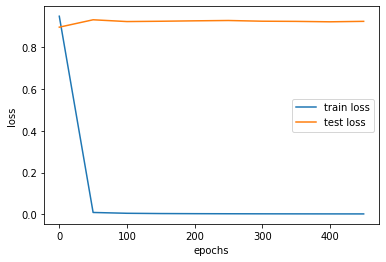

In [5]:
plt.plot(range(0,epochs,printInterval),
         trainLosses,label='train loss')
plt.plot(range(0,epochs,printInterval),
         testLosses,label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

In [6]:
targetUser,limit = 1,100
x1 = np.array([mf.mf.u2id[targetUser]]).reshape(1,1,1)
res = []
for i,movie in enumerate(mf.mf.allmovies):
    x2 = np.array([mf.mf.m2id[movie]]).reshape(1,1,1)
    pred=mf.model([x1,x2],training=False)+mf.mf.mean
    pred=pred.numpy()[0]
    if movie in mf.u2m[targetUser][0]:
        if i<limit:
            print("Movie {}: {} (truth) {:.4f} (pred)".format(\
            movie,mf.u2m[targetUser][0][movie],
            pred))
    else:
        store = -pred
        heappush(res,(store,movie))

Movie 2: 3.5 (truth) 3.5329 (pred)
Movie 29: 3.5 (truth) 3.5097 (pred)
Movie 32: 3.5 (truth) 4.1488 (pred)
Movie 47: 3.5 (truth) 3.5458 (pred)
Movie 50: 3.5 (truth) 3.5178 (pred)
Movie 112: 3.5 (truth) 3.5579 (pred)
Movie 151: 4.0 (truth) 3.6363 (pred)
Movie 223: 4.0 (truth) 4.0239 (pred)
Movie 253: 4.0 (truth) 4.2240 (pred)
Movie 260: 4.0 (truth) 3.9539 (pred)
Movie 293: 4.0 (truth) 4.0755 (pred)
Movie 296: 4.0 (truth) 4.0059 (pred)
Movie 318: 4.0 (truth) 4.0030 (pred)
Movie 337: 3.5 (truth) 3.5266 (pred)
Movie 367: 3.5 (truth) 3.4894 (pred)
Movie 541: 4.0 (truth) 3.9347 (pred)
Movie 589: 3.5 (truth) 3.5096 (pred)
Movie 593: 3.5 (truth) 3.4281 (pred)
Movie 653: 3.0 (truth) 3.0207 (pred)
Movie 919: 3.5 (truth) 3.5148 (pred)
Movie 924: 3.5 (truth) 3.5396 (pred)
Movie 1009: 3.5 (truth) 3.5597 (pred)
Movie 1036: 4.0 (truth) 4.0278 (pred)
Movie 1079: 4.0 (truth) 4.0070 (pred)
Movie 1080: 3.5 (truth) 3.5076 (pred)
Movie 1089: 3.5 (truth) 3.7746 (pred)
Movie 1090: 4.0 (truth) 4.0104 (pred)
M

In [7]:
res[:10]

[(-4.5128565, 1203),
 (-4.5045547, 2858),
 (-4.3558826, 1197),
 (-4.344192, 1206),
 (-4.3271666, 356),
 (-4.2016063, 30707),
 (-4.219839, 4979),
 (-4.307283, 54286),
 (-4.326242, 1234),
 (-4.313785, 1221)]